In [1]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution, NoiseTunnel
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

/home/stud1/anaconda3/envs/pritish/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gasf_img_path_lable1 = [
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GASFC_train_test_val/val/data_22_7/sample1_segment5_label1.jpeg",
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GASFC_train_test_val/val/data_22_13/sample1_segment12_label1.jpeg",
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GASFC_train_test_val/test/data_32_12/sample1_segment2_label1.jpeg",
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GASFC_train_test_val/test/data_32_12/sample1_segment101_label1.jpeg",
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GASFC_train_test_val/val/data_22_13/sample1_segment14_label1.jpeg",
]
gasf_img_path_lable0 = [
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GASFC_train_test_val/test/data_0_4/sample1_segment144_label0.jpeg",
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GASFC_train_test_val/test/data_0_8/sample1_segment7_label0.jpeg",
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GASFC_train_test_val/test/data_0_8/sample1_segment9_label0.jpeg",
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GASFC_train_test_val/test/data_15_10/sample1_segment6_label0.jpeg",
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GASFC_train_test_val/test/data_32_26/sample1_segment4_label0.jpeg",
]
gadf_img_path_lable1 = [
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GADFC_train_test_val/val/data_22_7/sample1_segment5_label1.jpeg",
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GADFC_train_test_val/val/data_22_13/sample1_segment12_label1.jpeg",
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GADFC_train_test_val/test/data_32_12/sample1_segment2_label1.jpeg",
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GADFC_train_test_val/test/data_32_12/sample1_segment101_label1.jpeg",
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GADFC_train_test_val/val/data_22_13/sample1_segment14_label1.jpeg",
]
gadf_img_path_lable0 = [
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GADFC_train_test_val/test/data_0_4/sample1_segment144_label0.jpeg",
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GADFC_train_test_val/test/data_0_8/sample1_segment7_label0.jpeg",
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GADFC_train_test_val/test/data_0_8/sample1_segment9_label0.jpeg",
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GADFC_train_test_val/test/data_15_10/sample1_segment6_label0.jpeg",
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GADFC_train_test_val/test/data_32_26/sample1_segment4_label0.jpeg",
]

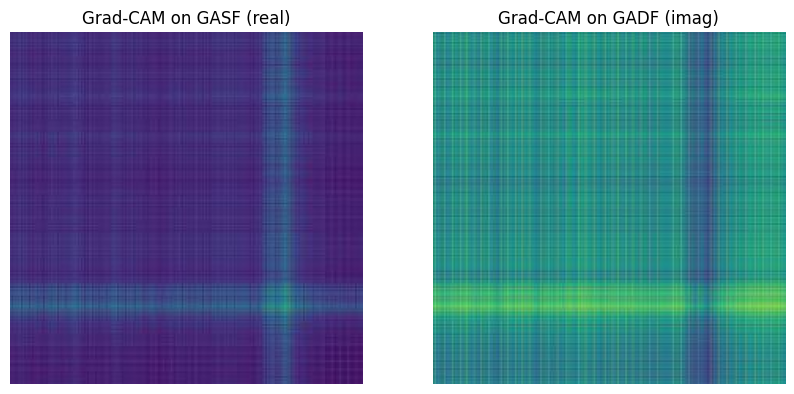

In [3]:
gasf_image = Image.open(
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GASFC_train_test_val/val/data_22_7/sample1_segment5_label1.jpeg"
).convert("RGB")
test_real_data = np.asarray(gasf_image)


gadf_image = Image.open(
    "/home/stud1/Desktop/nidhi/Diptiman/GAF_DATA2/GADFC_train_test_val/val/data_22_7/sample1_segment5_label1.jpeg"
).convert("RGB")
test_img_data = np.asarray(gadf_image)


# Show with matplotlib
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_real_data)
plt.title("Grad-CAM on GASF (real)")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(test_img_data)
plt.title("Grad-CAM on GADF (imag)")
plt.axis("off")
plt.show()

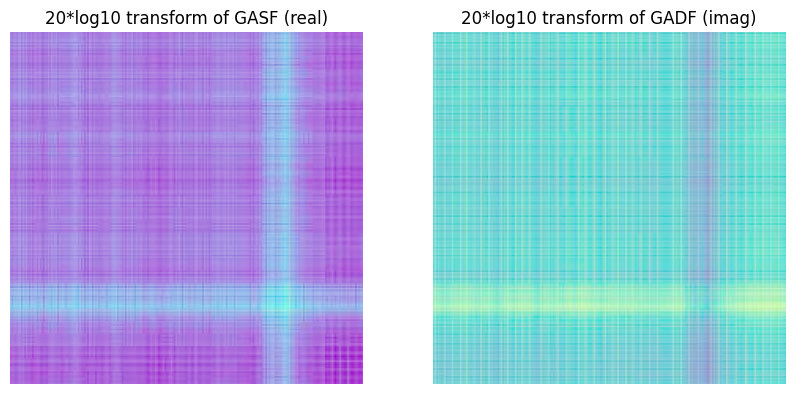

In [4]:
# Apply 20*log10 transformation to both images
epsilon = 1e-10  # Small constant to avoid log(0)

# Transform GASF data
log_real_data = 20 * np.log10(test_real_data.astype(float) + epsilon)

# Transform GADF data
log_img_data = 20 * np.log10(test_img_data.astype(float) + epsilon)


# Normalize for better visualization
def normalize_for_display(img):
    min_val = np.min(img)
    max_val = np.max(img)
    return (img - min_val) / (max_val - min_val)


norm_log_real = normalize_for_display(log_real_data)
norm_log_img = normalize_for_display(log_img_data)

# Show results with matplotlib
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(norm_log_real, cmap="magma")
plt.title("20*log10 transform of GASF (real)")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(norm_log_img, cmap="magma")
plt.title("20*log10 transform of GADF (imag)")
plt.axis("off")
plt.show()

In [5]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms

transforms_gadf = transforms.Compose(
    [
        transforms.Normalize(
            mean=[0.19756491, 0.5550784, 0.50753045],
            std=[0.08108524, 0.10870767, 0.05927933],
        ),
    ]
)
transforms_gasf = transforms.Compose(
    [
        transforms.Normalize(
            mean=[0.25332475, 0.17397244, 0.43626496],
            std=[0.03306787, 0.08601908, 0.04909801],
        ),
    ]
)
transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)
gadf = transforms(gadf_image)
gasf = transforms(gasf_image)

transformed_gadf_image = transforms_gadf(gadf)
transformed_gasf_image = transforms_gasf(gasf)

complex_r = torch.complex(transformed_gasf_image[0], transformed_gadf_image[0])
complex_g = torch.complex(transformed_gasf_image[1], transformed_gadf_image[1])
complex_b = torch.complex(transformed_gasf_image[2], transformed_gadf_image[2])

# Stack channels to form the final complex image
complex_image = torch.stack([complex_r, complex_g, complex_b], dim=0)
label = torch.tensor([1])

In [6]:
from data.dataloader import load_config
from models.DualStreamPhaseMagNet import dual_stream_phase_mag_resnet_18
from models.complex_resnet import complex_resnet18
from models.custom_resnet import resnet18
from models.hybrid_resnet import hybrid_resnet18
from models.hybrid_resnet_RO import hybrid_resnet_RO_18

config = load_config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

# Load the model
model = complex_resnet18(config)
# model = hybrid_resnet18()
# model = hybrid_resnet_RO_18()
# model = dual_stream_phase_mag_resnet_18()
state = torch.load(
    "ExplanableAi/Complex_Resnet18_GASF_iGADF_model_epoch_29.pth",
    map_location=device,
)
new_state = {k[7:] if k.startswith("module.") else k: v for k, v in state.items()}
model.load_state_dict(new_state, strict=True)
model = model.to(device)
model = model.eval()

input_image = complex_image.unsqueeze(0).to(device)
label = label.to(device)
# Forward pass to get the model output
output = model(input_image)
print(f"Model output: {output}")
pred = torch.sigmoid(output).view(-1)
print(f"Raw prediction: {pred.item()}")
pred = (pred > 0.5).float()  # Convert to binary prediction
print(f"Prediction: {pred.item()}")

if isinstance(model, torch.nn.DataParallel):
    model = model.module

## Given complex image
real = input_image.real  # shape: (1, 3, 224, 224)
imag = input_image.imag  # shape: (1, 3, 224, 224)

x_captum = torch.cat([real, imag], dim=1)  # shape: (1, 6, 224, 224)
x_captum.requires_grad_()

Using device: cuda
Creating complex ResNet-18 with 3 complex channels and 1 classes


Model output: tensor([[8.1437]], device='cuda:0', grad_fn=<AddmmBackward0>)
Raw prediction: 0.9997095465660095
Prediction: 1.0


tensor([[[[ 0.4035, -0.0709,  0.2849,  ...,  0.5221,  0.6407,  0.7592],
          [ 0.1663, -0.3081,  0.1663,  ...,  0.8778,  0.9964,  1.1150],
          [ 0.4035,  0.0477,  0.5221,  ...,  0.7592,  0.8778,  0.9964],
          ...,
          [ 0.5221,  0.7592,  0.5221,  ...,  0.2849,  0.2849,  0.6407],
          [ 0.6407,  0.9964,  0.6407,  ...,  0.1663,  0.1663,  0.6407],
          [ 0.7592,  1.1150,  0.8778,  ...,  0.4035,  0.4035,  0.8778]],

         [[ 0.0746, -0.1077,  0.0746,  ..., -0.6548, -0.6092, -0.5636],
          [-0.0165, -0.1533,  0.0290,  ..., -0.5180, -0.4724, -0.4269],
          [ 0.1202, -0.0165,  0.1658,  ..., -0.4724, -0.4269, -0.3813],
          ...,
          [-0.5636, -0.4724, -0.4724,  ..., -1.1107, -1.1107, -0.9739],
          [-0.5180, -0.3813, -0.4269,  ..., -1.1563, -1.1563, -0.9739],
          [-0.4724, -0.3357, -0.3357,  ..., -1.0651, -1.0651, -0.8827]],

         [[ 0.7789,  0.4595,  0.7789,  ..., -0.0198,  0.0601,  0.1400],
          [ 0.6192,  0.3796,  

## Feature Attribution with Integrated Gradients

**Feature attribution** attributes a particular output to features of the input. It uses a specific input - here, our test image - to generate a map of the relative importance of each input feature to a particular output feature.

[**Integrated Gradients**](https://captum.ai/api/integrated_gradients.html) is one of the feature attribution algorithms available in Captum. Integrated Gradients assigns an importance score to each input feature by approximating the integral of the gradients of the model's output with respect to the inputs.

In our case, we're going to be taking a specific element of the output vector - that is, the one indicating the model's confidence in its chosen category - and use Integrated Gradients to understand what parts of the input image contributed to this output.

Once we have the importance map from Integrated Gradients, we'll use the visualization tools in Captum to give a helpful representation of the importance map. Captum's `visualize_image_attr()` function provides a variety of options for customizing display of your attribution data. Here, we pass in a custom Matplotlib color map.

Running the cell with the `integrated_gradients.attribute()` call will usually take a minute or two.

In [7]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(model)
attributions = ig.attribute(x_captum, target=0, n_steps=10)

real_attributions = attributions[:, :3, :, :]  # shape: (1, 3, 224, 224)
imag_attributions = attributions[:, 3:, :]  # shape: (1, 3, 224, 224)
default_cmap = LinearSegmentedColormap.from_list(
    "custom blue", [(0, "#ffffff"), (0.25, "#0000ff"), (1, "#0000ff")], N=256
)
_ = viz.visualize_image_attr_multiple(
    np.transpose(real_attributions.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(gasf.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    ["original_image", "heat_map"],
    ["all", "positive"],
    show_colorbar=True,
    cmap=default_cmap,
    titles=["Original", "Positive Attribution"],
    fig_size=(10, 6),
)
_ = viz.visualize_image_attr_multiple(
    np.transpose(imag_attributions.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(gadf.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    ["original_image", "heat_map"],
    ["all", "positive"],
    show_colorbar=True,
    cmap=default_cmap,
    titles=["Original", "Positive Attribution"],
    fig_size=(10, 6),
)

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[10, 6, 224, 224] to have 3 channels, but got 6 channels instead

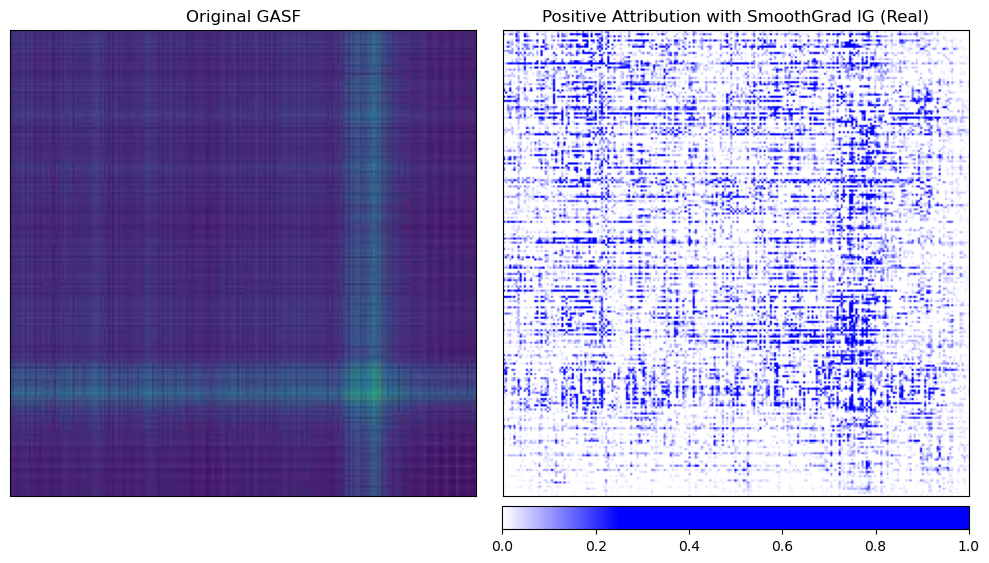

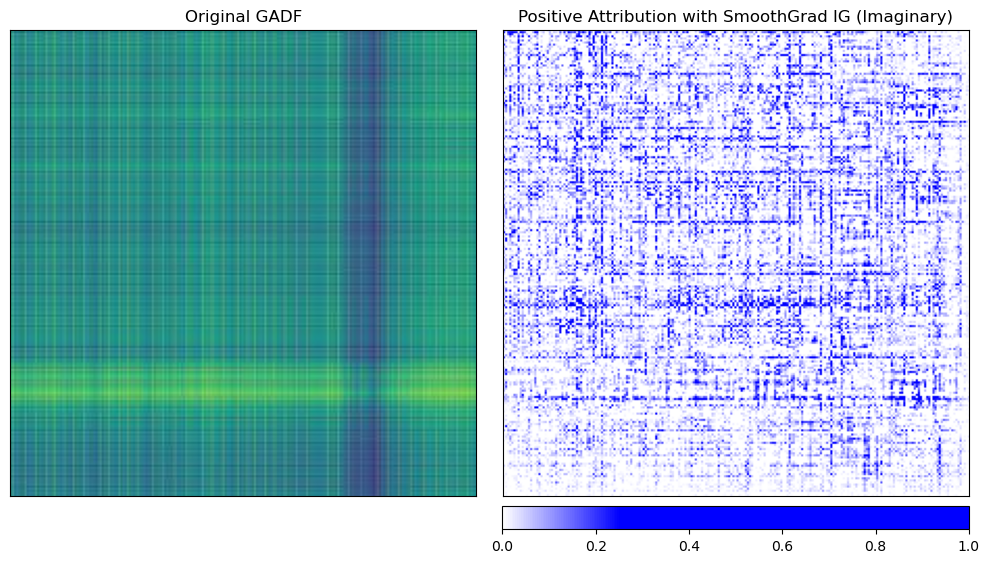

In [ ]:
from captum.attr import NoiseTunnel

# Create a NoiseTunnel wrapper around the IntegratedGradients instance
noise_tunnel = NoiseTunnel(ig)

# Get attributions with noise tunnel
attributions_ig_nt = noise_tunnel.attribute(
    x_captum, nt_samples=2, nt_type="smoothgrad", target=0
)

# Split into real and imaginary parts
real_attributions_nt = attributions_ig_nt[:, :3, :, :]  # shape: (1, 3, 224, 224)
imag_attributions_nt = attributions_ig_nt[:, 3:, :]  # shape: (1, 3, 224, 224)

# Visualize real part with noise tunnel
_ = viz.visualize_image_attr_multiple(
    np.transpose(real_attributions_nt.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(gasf.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    ["original_image", "heat_map"],
    ["all", "positive"],
    cmap=default_cmap,
    show_colorbar=True,
    titles=["Original GASF", "Positive Attribution with NoiseTunnel (Real)"],
    fig_size=(10, 6),
)

# Visualize imaginary part with noise tunnel
_ = viz.visualize_image_attr_multiple(
    np.transpose(imag_attributions_nt.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(gadf.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    ["original_image", "heat_map"],
    ["all", "positive"],
    cmap=default_cmap,
    show_colorbar=True,
    titles=["Original GADF", "Positive Attribution with NoiseTunnel (Imaginary)"],
    fig_size=(10, 6),
)

## Feature Attribution with Occlusion

Gradient-based attribution methods help to understand the model in terms of directly computing out the output changes with respect to the input. *Perturbation-based attribution* methods approach this more directly, by introducing changes to the output to measure the effect on the output. [**Occlusion**](https://captum.ai/api/occlusion.html) is one such method. It involves replacing sections of the input image, and examining the effect on the output signal.

Below, we set up Occlusion attribution. Similarly to configuring a convolutional neural network, you can specify the size of the target region, and a stride length to determine the spacing of individual measurements. We'll visualize the output of our Occlusion attribution with `visualize_image_attr_multiple()`, showing heat maps of both positive and negative attribution by region, and by masking the original image with the positive attribution regions. The masking gives a very instructive view of what regions of our cat photo the model found to be most "cat-like".

In [ ]:
# occlusion = Occlusion(model)

# attributions_occ = occlusion.attribute(
#     x_captum,
#     target=0,
#     strides=(6, 4, 4),
#     sliding_window_shapes=(6, 15, 15),
#     baselines=0,
# )

# real_attributions_occ = attributions_occ[:, :3, :, :]  # shape: (1, 3, 224, 224)
# imag_attributions_occ = attributions_occ[:, 3:, :]  # shape: (1, 3, 224, 224)

# _ = viz.visualize_image_attr_multiple(
#     np.transpose(real_attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)),
#     np.transpose(gasf.squeeze().cpu().detach().numpy(), (1, 2, 0)),
#     ["original_image", "heat_map", "heat_map", "masked_image"],
#     ["all", "positive", "negative", "positive"],
#     show_colorbar=True,
#     titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
#     fig_size=(18, 6),
# )
# _ = viz.visualize_image_attr_multiple(
#     np.transpose(imag_attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0)),
#     np.transpose(gadf.squeeze().cpu().detach().numpy(), (1, 2, 0)),
#     ["original_image", "heat_map", "heat_map", "masked_image"],
#     ["all", "positive", "negative", "positive"],
#     show_colorbar=True,
#     titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
#     fig_size=(18, 6),
# )

### Grad Cam

In [ ]:
from models.complex_resnet import complex_resnet18


class ComplexResNetCAM(torch.nn.Module):
    def __init__(self, config, checkpoint_path, device):
        super().__init__()
        self.model = complex_resnet18(config)
        state = torch.load(checkpoint_path, map_location=device)
        new_state = {
            k[7:] if k.startswith("module.") else k: v for k, v in state.items()
        }
        self.model.load_state_dict(new_state, strict=True)
        self.model.to(device).eval()

        # We want to hook the *module*, not a tensor
        target = self.model.layer4[-1].conv2  # the ComplexConv2d layer
        self.gradients = None

        # forward hook to save the activation
        def forward_hook(module, inp, out):
            # out is complex; we'll store it for later
            self.activations = out

        # backward hook to save grad of that activation
        def backward_hook(module, grad_in, grad_out):
            # grad_out[0] is dL/d(out)
            self.gradients = grad_out[0]

        target.register_forward_hook(forward_hook)
        target.register_full_backward_hook(backward_hook)

    def forward(self, x):
        # pre‐process to complex
        if not torch.is_complex(x):
            real, imag = x[:, :3], x[:, 3:]
            x = torch.complex(real, imag)

        # run entire model straight through
        return self.model(x)

    def get_activations(self):
        return self.activations

    def get_activations_gradient(self):
        return self.gradients

In [ ]:
import torch
import torch.nn as nn
from models.hybrid_resnet import hybrid_resnet18  # your model


class HybridResNetCAM(nn.Module):
    def __init__(self, config, checkpoint_path, device):
        super().__init__()
        self.model = hybrid_resnet18()
        state = torch.load(checkpoint_path, map_location=device)
        new_state = {
            k[7:] if k.startswith("module.") else k: v for k, v in state.items()
        }
        self.model.load_state_dict(new_state)
        self.model.to(device).eval()

        # Store activations and gradients
        self.activations_real = None
        self.activations_imag = None
        self.gradients_real = None
        self.gradients_imag = None

        # Register hooks on the last blocks of layer4_real and layer4_imag
        self.model.layer4_real[-1].register_forward_hook(self._hook_real_forward)
        self.model.layer4_imag[-1].register_forward_hook(self._hook_imag_forward)

        self.model.layer4_real[-1].register_full_backward_hook(self._hook_real_backward)
        self.model.layer4_imag[-1].register_full_backward_hook(self._hook_imag_backward)

    def _hook_real_forward(self, module, input, output):
        self.activations_real = output

    def _hook_imag_forward(self, module, input, output):
        self.activations_imag = output

    def _hook_real_backward(self, module, grad_input, grad_output):
        self.gradients_real = grad_output[0]

    def _hook_imag_backward(self, module, grad_input, grad_output):
        self.gradients_imag = grad_output[0]

    def forward(self, x):
        if not torch.is_complex(x):
            real, imag = x[:, :3], x[:, 3:]
            x = torch.complex(real, imag)
        return self.model(x)

    def get_activations(self):
        if self.activations_real is not None and self.activations_imag is not None:
            return torch.complex(self.activations_real, self.activations_imag)
        return None

    def get_activations_gradient(self):
        if self.gradients_real is not None and self.gradients_imag is not None:
            return torch.complex(self.gradients_real, self.gradients_imag)
        return None

In [ ]:
class HybridResNetROCAM(torch.nn.Module):
    def __init__(self, config, checkpoint_path, device):
        super().__init__()
        self.model = hybrid_resnet_RO_18()
        state = torch.load(checkpoint_path, map_location=device)
        new_state = {
            k[7:] if k.startswith("module.") else k: v for k, v in state.items()
        }
        self.model.load_state_dict(new_state, strict=True)
        self.model.to(device).eval()

        # Hook on the complex conv2 layer of the last block in layer4
        target = self.model.layer4[-1].conv2
        self.gradients = None

        def forward_hook(module, inp, out):
            self.activations = out  # complex-valued activations

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[
                0
            ]  # grad_out is a tuple; grad_out[0] is the complex gradient

        target.register_forward_hook(forward_hook)
        target.register_full_backward_hook(backward_hook)

    def forward(self, x):
        # Expecting real + imaginary in x as two 3-channel images
        if not torch.is_complex(x):
            real, imag = x[:, :3], x[:, 3:]
            x = torch.complex(real, imag)
        return self.model(x)

    def get_activations(self):
        return self.activations

    def get_activations_gradient(self):
        return self.gradients

In [ ]:
class DualStreamPhaseMagNetCAM(torch.nn.Module):
    def __init__(self, config, checkpoint_path, device):
        super().__init__()

        self.model = dual_stream_phase_mag_resnet_18()
        state = torch.load(checkpoint_path, map_location=device)
        new_state = {
            k[7:] if k.startswith("module.") else k: v for k, v in state.items()
        }
        self.model.load_state_dict(new_state, strict=True)
        self.model.to(device).eval()

        self.gradients_mag = None
        self.activations_mag = None
        self.gradients_phase = None
        self.activations_phase = None

        # Hooks for magnitude branch
        def forward_hook_mag(module, inp, out):
            self.activations_mag = out

        def backward_hook_mag(module, grad_in, grad_out):
            self.gradients_mag = grad_out[0]

        # Hooks for phase branch
        def forward_hook_phase(module, inp, out):
            self.activations_phase = out

        def backward_hook_phase(module, grad_in, grad_out):
            self.gradients_phase = grad_out[0]

        self.model.layer4_mag[-1].conv2.register_forward_hook(forward_hook_mag)
        self.model.layer4_mag[-1].conv2.register_full_backward_hook(backward_hook_mag)
        self.model.layer4_phase[-1].conv2.register_forward_hook(forward_hook_phase)
        self.model.layer4_phase[-1].conv2.register_full_backward_hook(backward_hook_phase)

    def forward(self, x):
        if not torch.is_complex(x):
            real, imag = x[:, :3], x[:, 3:]
            x = torch.complex(real, imag)
        return self.model(x)

    def get_activations(self):
        return torch.complex(self.activations_mag, self.activations_phase)

    def get_activations_gradient(self):
        return torch.complex(self.gradients_mag, self.gradients_phase)

Creating complex ResNet-18 with 3 complex channels and 1 classes
Prediction: True
Gradients: torch.Size([1, 512, 7, 7]) torch.complex64
Activations: torch.Size([1, 512, 7, 7]) torch.complex64


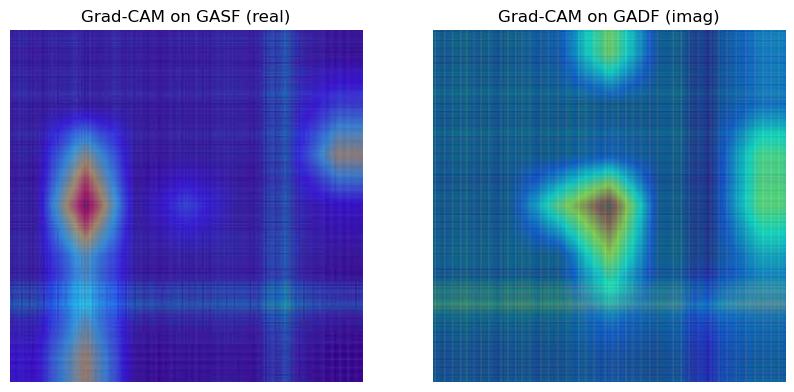

In [ ]:
from data.dataloader import load_config


config = load_config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = "saved_models/Complex_Resnet18_GADF_iGADF/Complex_Resnet18_GADF_iGADF_model_epoch_29.pth"

# 1) Build and load
cam_model = ComplexResNetCAM(config, checkpoint, device)
# cam_model = HybridResNetCAM(config, checkpoint, device)
# cam_model = HybridResNetROCAM(config, checkpoint, device)
# cam_model = DualStreamPhaseMagNetCAM(config, checkpoint, device)
# 2) Prepare input
complex_img = complex_image.unsqueeze(0).to(device)
inp = torch.cat([complex_img.real, complex_img.imag], dim=1)
inp.requires_grad_()

# 3) Forward + backward
cam_model.zero_grad()
logit = cam_model(inp)  # forward through full model
logit[0, 0].backward()  # backward from the single logit
pred = torch.sigmoid(logit) > 0.5
print("Prediction:", pred.item())
# 4) Retrieve
grads = cam_model.get_activations_gradient()  # will be a complex tensor gradient
acts = cam_model.get_activations()  # the complex activations

print("Gradients:", grads.shape, grads.dtype)
print("Activations:", acts.shape, acts.dtype)
real_grads = grads.real
imag_grads = grads.imag
real_acts = acts.real
imag_acts = acts.imag

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2


def compute_gradcam_heatmap(activations, gradients):
    """
    activations: Tensor of shape [1, C, h, w]
    gradients:   Tensor of shape [1, C, h, w]
    returns:     heatmap np.ndarray of shape [h, w] in [0,1]
    """
    # 1) Pool gradients across spatial dims → [C]
    pooled = gradients.mean(dim=[0, 2, 3])  # shape [C]

    # 2) Weight channels
    weighted = activations.clone()
    for i in range(weighted.shape[1]):
        weighted[:, i, :, :] *= pooled[i]

    # 3) Average across channels → [1, h, w]
    heatmap = weighted.mean(
        dim=1, keepdim=True
    )  # [1,1,h,w] if keepdim, but here [1,h,w]
    heatmap = F.relu(heatmap)  # only positives
    heatmap = heatmap.squeeze().cpu().detach().numpy()

    # 4) Normalize to [0,1]
    heatmap = np.maximum(heatmap, 0)
    if heatmap.max() > 0:
        heatmap /= heatmap.max()
    return heatmap


# Compute two heatmaps
heatmap_real = compute_gradcam_heatmap(real_acts, real_grads)
heatmap_imag = compute_gradcam_heatmap(imag_acts, imag_grads)

# # Show the heatmaps
# plt.figure(figsize=(5, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(heatmap_real, cmap="jet")
# plt.title("Real Part Heatmap")
# plt.axis("off")
# plt.subplot(1, 2, 2)
# plt.imshow(heatmap_imag, cmap="jet")
# plt.title("Imaginary Part Heatmap")
# plt.axis("off")
# plt.tight_layout()
# plt.show()


# Resize & overlay function
def overlay_on_original(original_image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    original_complex:  Tensor [1,3,H,W] complex
    heatmap:           np.ndarray [h,w] normalized [0,1]
    returns:           BGR overlay np.ndarray [H,W,3]
    """
    bg = original_image.cpu().numpy().transpose(1, 2, 0)  # [H,W,3] in RGB
    bg = cv2.cvtColor(bg, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV

    # Normalize to [0,255]
    bg = (255 * (bg - bg.min()) / (bg.max() - bg.min() + 1e-8)).astype(np.uint8)

    H, W = bg.shape[:2]
    hm_resized = cv2.resize(heatmap, (W, H))
    hm_uint8 = np.uint8(255 * hm_resized)
    hm_color = cv2.applyColorMap(hm_uint8, colormap)
    overlay = cv2.addWeighted(hm_color, alpha, bg, 1 - alpha, 0)
    return overlay


# Prepare your original GAF images:
# complex_img: [1,3,H,W] complex (GASF in real, GADF in imag)
overlay_real = overlay_on_original(gasf, heatmap_real)
overlay_imag = overlay_on_original(gadf, heatmap_imag)

# Show with matplotlib (convert BGR to RGB)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(overlay_real, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM on GASF (real)")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay_imag, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM on GADF (imag)")
plt.axis("off")
plt.show()